数据集形状: (1757, 26)
缺失值统计:
Environment        1757
Unnamed: 24        1757
Trans Mode         1757
Grade              1757
Crop               1757
Storage            1757
Appearance         1757
Condition          1757
Quality            1757
Type               1712
Unnamed: 25        1654
Origin District    1626
Unit of Sale       1595
Sub Variety        1461
Color               616
Item Size           279
Mostly High         103
Mostly Low          103
Variety               5
Origin                3
High Price            0
Low Price             0
Date                  0
Repack                0
Package               0
City Name             0
dtype: int64


C:\Users\86182\AppData\Local\Temp\ipykernel_7596\1024948219.py:31: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['Date'] = pd.to_datetime(df['Date'])


Mean Squared Error: 669.5097294213606
R² Score: 0.9102516141544978


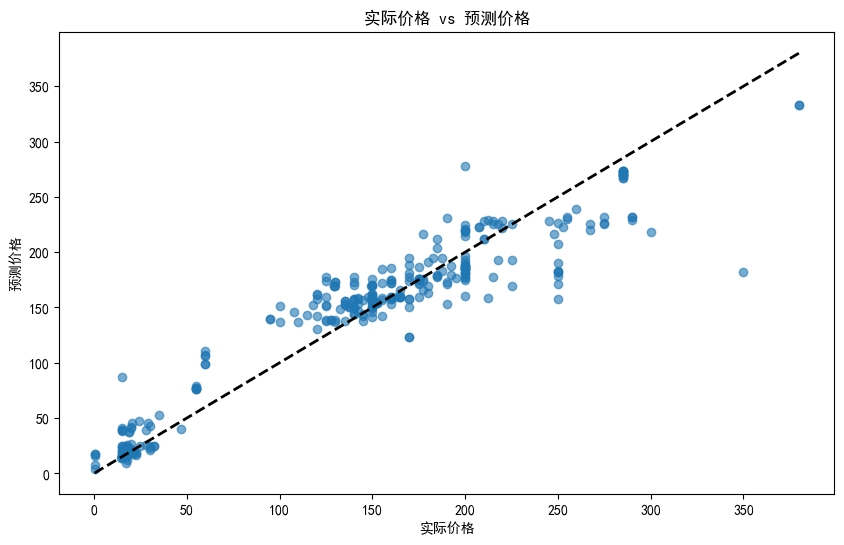

In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer

# 加载数据
df = pd.read_csv('US-pumpkins.csv')

# 设置中文显示
plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['axes.unicode_minus'] = False

# 基础信息
print(f"数据集形状: {df.shape}")
print(f"缺失值统计:\n{df.isnull().sum().sort_values(ascending=False)}")

# 目标变量创建
df['Avg_Price'] = (df['Mostly Low'] + df['Mostly High']) / 2

# 关键特征选择
features = ['City Name', 'Package', 'Variety', 'Origin', 'Item Size', 'Color', 'Unit of Sale']
df = df[features + ['Date', 'Avg_Price']].copy()

# 日期特征工程
df['Date'] = pd.to_datetime(df['Date'])
df['Month'] = df['Date'].dt.month
df['Week'] = df['Date'].dt.isocalendar().week

# 定义分类和数值特征
categorical_features = ['City Name', 'Package', 'Variety', 'Origin', 'Item Size', 'Color', 'Unit of Sale']
numerical_features = ['Month', 'Week']

# 缺失值处理
# 对于分类特征，使用最频繁出现的值来填充缺失值
imputer_cat = SimpleImputer(strategy='most_frequent')
df[categorical_features] = imputer_cat.fit_transform(df[categorical_features])

# 对于数值特征，使用均值来填充缺失值
imputer_num = SimpleImputer(strategy='mean')
df[numerical_features] = imputer_num.fit_transform(df[numerical_features])

# 异常值处理
Q1 = df['Avg_Price'].quantile(0.25)
Q3 = df['Avg_Price'].quantile(0.75)
IQR = Q3 - Q1
df = df[~((df['Avg_Price'] < (Q1 - 1.5 * IQR)) | (df['Avg_Price'] > (Q3 + 1.5 * IQR)))]

# 特征编码和标准化
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ])

# 创建管道
model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', GradientBoostingRegressor(random_state=42))
])

# 删除目标变量中包含缺失值的行
df = df.dropna(subset=['Avg_Price'])

# 重新定义X和y
X = df.drop(columns=['Avg_Price'])
y = df['Avg_Price']

# 数据划分
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 模型训练
model.fit(X_train, y_train)

# 模型预测
y_pred = model.predict(X_test)

# 模型评估
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f'Mean Squared Error: {mse}')
print(f'R² Score: {r2}')

# 绘制实际值与预测值的对比图
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.6)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)
plt.xlabel('实际价格')
plt.ylabel('预测价格')
plt.title('实际价格 vs 预测价格')
plt.show()